<a href="https://colab.research.google.com/github/KushanChamindu/Canny-Edge-Detection/blob/main/Canny_edge_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
from google.colab import drive


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
image_path ='/content/drive/MyDrive/Semester 7/Computer vision/images/'

In [100]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import sys
import glob
import numpy
import numpy as np

img = cv.imread(cv.samples.findFile(image_path+"cameramanN1.jpg"))
if img is None:
  sys.exit("Could not read the image.")

In [50]:
def convert2gray(img):
    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]    ## seperate r,gb, values
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b     ## convert to gray scale based on sensivity level in human eye
    return gray

In [51]:
def generate_gaussian_kernel(kernal_size, sigma=1):
  gaussian_kernal = np.zeros((kernal_size, kernal_size), np.float32)
  i = kernal_size//2
  j = kernal_size//2

  for x in range(-i, i+1):
      for y in range(-j, j+1):
          normal  = 2*np.pi*(sigma**2)
          g = np.exp(-(x**2 + y**2)/(2*sigma**2))
          gaussian_kernal[x+i, y+j] = (1/normal)*g 
  return gaussian_kernal/gaussian_kernal.sum()
generate_gaussian_kernel(3)

array([[0.07511362, 0.12384141, 0.07511362],
       [0.12384141, 0.20417996, 0.12384141],
       [0.07511362, 0.12384141, 0.07511362]], dtype=float32)

In [52]:
def matrix_convolution(image, kernal):
  image_copy = image.copy()
  kernal_size = len(kernal)
  #### Wrap the image for filtering
  for k in range(len(image)):
    for i in range(kernal_size//2):
      image_copy[k].insert(0,image[k][-1-(i*2)])
      image_copy[k].append(image[k][1+(i*2)])
  for i in range(kernal_size//2):
    image_copy.insert(0,image[-1-i].copy())
    image_copy.append(image[i].copy())

  image_x = len(image_copy)
  image_y = len(image_copy[0])
  result= []
  kernal_middle = kernal_size//2
  for x in range(kernal_middle, image_x - kernal_middle):
    temp = []
    for y in range(kernal_middle, image_y - kernal_middle):
      value = 0
      for i in range(len(kernal)):
        for j in range(len(kernal)):
          xn = x + i - kernal_middle
          yn = y + j - kernal_middle
          filtered_value = kernal[i][j]*image_copy[xn][yn]
          value += filtered_value
      temp.append(value)
    result.append(temp)
  return np.array(result)

In [53]:
B = np.array([[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]])
C = np.array([[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]])
matrix_convolution(B.tolist(),C.tolist())

array([[16, 16, 16, 16],
       [16, 16, 16, 16],
       [16, 16, 16, 16],
       [16, 16, 16, 16],
       [16, 16, 16, 16]])

In [54]:
from scipy import ndimage
ndimage.filters.convolve(B, C)

array([[16, 16, 16, 16],
       [16, 16, 16, 16],
       [16, 16, 16, 16],
       [16, 16, 16, 16],
       [16, 16, 16, 16]])

In [55]:
def gradient_estimation(img, estimation_type):
  assert (estimation_type in ["Prewitt", "Sobel", "Robert"]), "estimation_type should be  in [\"Prewitt\", \"Sobel\", \"Robert\"]"
  if estimation_type == "Prewitt":
    M_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], np.float32)
    M_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], np.float32)
  elif estimation_type == "Sobel":
    M_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    M_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
  else:
    M_x = np.array([[0, 1], [-1, 0]], np.float32)
    M_y = np.array([[1, 0], [0, -1]], np.float32)
   
  G_x = matrix_convolution(img.tolist(), M_x.tolist())
  G_y = matrix_convolution(img.tolist(), M_y.tolist())

  G = (G_x**2 + G_y**2)**0.5
  G = G / G.max() * 255
  theta = np.arctan2(G_x, G_y)

  return (G,theta)

In [87]:
def non_max_suppression(img, angles):
  size = img.shape
  angles = angles * 180. / np.pi  ## convert radian to degrees
  angles[angles < 0] += 180
  suppressed = np.zeros(size)
  for i in range(1, size[0] - 1):
      for j in range(1, size[1] - 1):
          if (0 <= angles[i, j] < 22.5) or (157.5 <= angles[i, j] <= 180):
              value_to_compare = max(img[i, j+1], img[i, j-1])
          elif (22.5 <= angles[i, j] < 67.5):
              value_to_compare = max(img[i+1, j-1], img[i-1, j+1])
          elif (67.5 <= angles[i, j] < 112.5):
              value_to_compare = max(img[i+1, j], img[i-1, j])
          elif (112.5 <= angles[i,j] < 157.5):
              value_to_compare = max(img[i-1, j-1], img[i+1, j+1])
          
          if img[i, j] >= value_to_compare:
            suppressed[i, j] = img[i, j]
          else:
            suppressed[i, j] = 0
  # suppressed = np.multiply(suppressed, 255.0 / suppressed.max())
  return suppressed

In [92]:
def double_threshold(img, lower_threshold=0.05, high_threshold= 0.09):
  high_threshold = img.max() * high_threshold
  lower_threshold = high_threshold * lower_threshold

  size = img.shape
  res = np.zeros(size, dtype=np.int32)
  
  weak = np.int32(25)
  strong = np.int32(255)
  
  for i in range(1, size[0] - 1):
    for j in range(1, size[1] - 1):
      if img[i,j] >= high_threshold:
        res[i, j] = strong
      elif img[i,j] >= lower_threshold and img[i,j] <= high_threshold:
        res[i, j] = weak
  return res

original image 



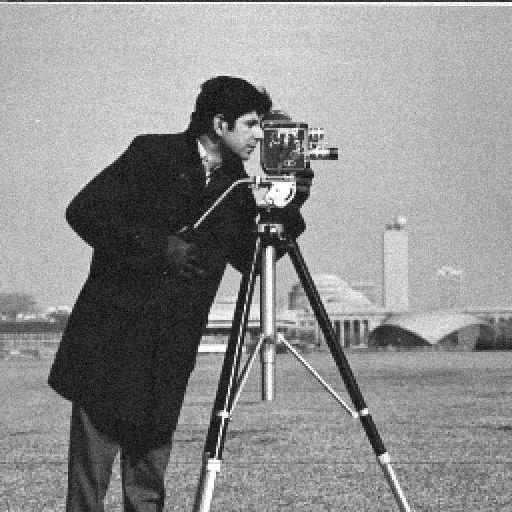

Gray scalled image 



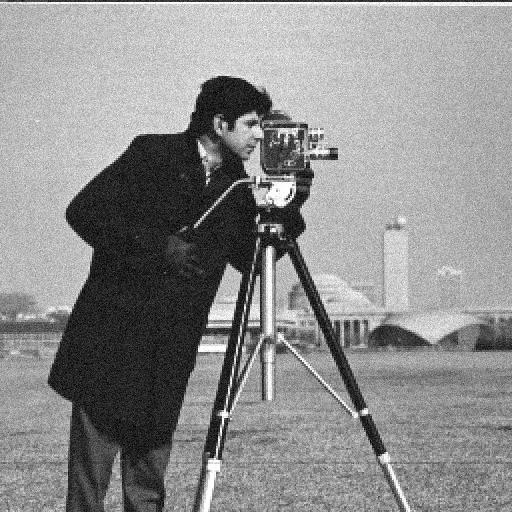

Gaussian filtered image 



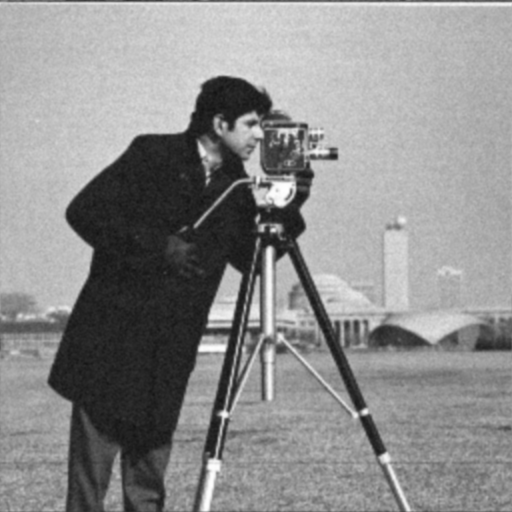

Gradient estimated image 



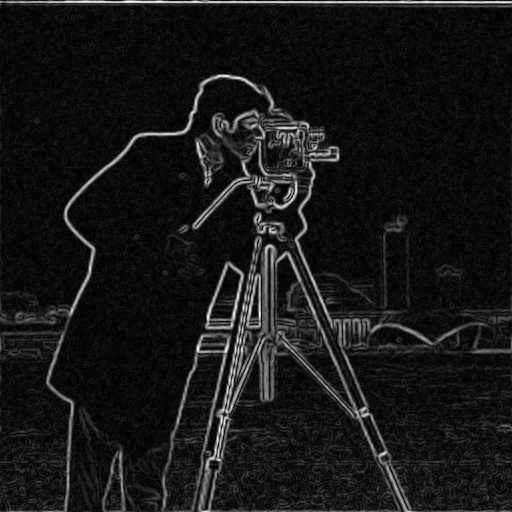

Suppressed image 



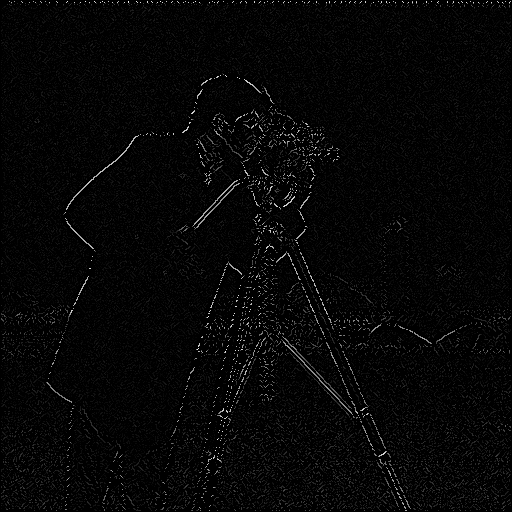

After double treshold image 



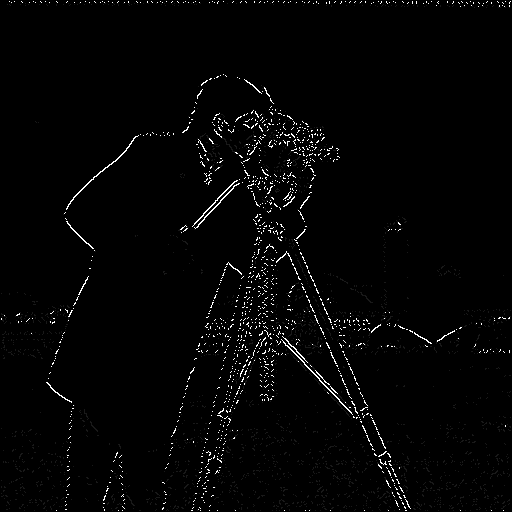

In [113]:
def canny_edge_detection(img,gaussian_kernal_size, estimation_method= "Prewitt",lower_threshold=0.5, high_threshold= 0.3):
  print("original image \n")
  cv2_imshow(img)
  # Step 1 : Convert image into gray scal image
  img_gray = convert2gray(img)
  print("Gray scalled image \n")
  cv2_imshow(img_gray)

  # Step 2 : Apply gaussian filter
  gaussian_kernal = generate_gaussian_kernel(gaussian_kernal_size)
  gaussian_filtered_img = matrix_convolution(img_gray.tolist(),gaussian_kernal)
  print("Gaussian filtered image \n")
  cv2_imshow(gaussian_filtered_img)
  

  # Step 3 : Gradient estimation
  (G,theta) = gradient_estimation(gaussian_filtered_img, estimation_method)
  print("Gradient estimated image \n")
  cv2_imshow(G)

  # Step 4 : Non-Maximum Suppression
  suppressed = non_max_suppression(G, theta)
  print("Suppressed image \n")
  cv2_imshow(suppressed)

  # Step 5 : Double threshold
  final_edge_detection = double_threshold(suppressed, lower_threshold=lower_threshold, high_threshold= high_threshold)
  print("After double treshold image \n")
  cv2_imshow(final_edge_detection)
canny_edge_detection(img, 5, "Sobel")